# Adult Census Salary Dataset - PyMongo

This Machine Learning analyses friendly Adult Census Income dataset, provided by UCI. It is used to model an income classification system to predict whether income exceeds $50K per annum based on census data. The data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). 


### Data Setup

In [176]:
# for python interpreter 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [177]:
# import block

import pymongo # pymongo package to connect with mongodb
from pymongo import MongoClient  
import pprint #for pretty printing
import re
import warnings
warnings.simplefilter('ignore')

In [178]:
# to connect to MongoClient localhost
client = MongoClient('localhost', 27017)

In [179]:
# database 'assignments' and dataset 'adultcensus' being selected

db = client['assignments']
collection = db['adultcensus']
cur_adultcensus = collection.find()

### MongoDB Queries

In [180]:
# to check document count
total = collection.count_documents({})
print("Total document count in the collection is ", total)

Total document count in the collection is  32561


In [181]:
# for loop to iterate through the documents in the cursor
# limit(1) to display a single record to understand schema
for doc in collection.find().limit(1):
    pprint.pprint (doc)

{'_id': ObjectId('5e4a23cd61c3cdf1528a4508'),
 'age': 90,
 'capital_gain': 0,
 'capital_loss': 4356,
 'education': 'HS-grad',
 'education_num': 9,
 'fnlwgt': 77053,
 'hours_per_week': 40,
 'income': '<=50K',
 'marital_status': 'Widowed',
 'native_country': 'United-States',
 'occupation': '?',
 'race': 'White',
 'relationship': 'Not-in-family',
 'sex': 'Female',
 'workclass': '?'}


In [182]:
# Query 1 – Distinct entries of education, occupation, & workclass
# to understand the dataset

db.adultcensus.distinct("education")
db.adultcensus.distinct("occupation")
db.adultcensus.distinct("workclass")


['10th',
 '11th',
 '12th',
 '1st-4th',
 '5th-6th',
 '7th-8th',
 '9th',
 'Assoc-acdm',
 'Assoc-voc',
 'Bachelors',
 'Doctorate',
 'HS-grad',
 'Masters',
 'Preschool',
 'Prof-school',
 'Some-college']

['?',
 'Adm-clerical',
 'Armed-Forces',
 'Craft-repair',
 'Exec-managerial',
 'Farming-fishing',
 'Handlers-cleaners',
 'Machine-op-inspct',
 'Other-service',
 'Priv-house-serv',
 'Prof-specialty',
 'Protective-serv',
 'Sales',
 'Tech-support',
 'Transport-moving']

['?',
 'Federal-gov',
 'Local-gov',
 'Never-worked',
 'Private',
 'Self-emp-inc',
 'Self-emp-not-inc',
 'State-gov',
 'Without-pay']

In [183]:
# Query 2 – The dataset is skewed towards people with native country as the US
# In the given dataset people with the US as their native country has close to 90% share, 
# it is certainly due to the higher proportion of the people native to the US. 
# The query aggregate documents by native_country, calculates counts and percentage respectively.


pipe =     [{ "$group" : { 
                "_id" : "$native_country", 
                "count" : { "$sum" : 1}}}, 
        { "$sort" : {"count" : -1 } }, 
        { "$limit" : 10 }, 
        {"$project" : { 
                "count" : "$count", 
                "percentage" : { "$concat" : [{ "$substr" : [{ 
                                    "$multiply" : [{ "$divide" : [
                                                "$count", total]}, 100]}, 0,4]}, "", "%"]}}}]
# store results in a cursor
cursor = collection.aggregate(pipeline = pipe)

# for loop to iterate through the documents in the cursor
for doc in cursor:
    pprint.pprint(doc)

{'_id': 'United-States', 'count': 29170, 'percentage': '89.5%'}
{'_id': 'Mexico', 'count': 643, 'percentage': '1.97%'}
{'_id': '?', 'count': 583, 'percentage': '1.79%'}
{'_id': 'Philippines', 'count': 198, 'percentage': '0.60%'}
{'_id': 'Germany', 'count': 137, 'percentage': '0.42%'}
{'_id': 'Canada', 'count': 121, 'percentage': '0.37%'}
{'_id': 'Puerto-Rico', 'count': 114, 'percentage': '0.35%'}
{'_id': 'El-Salvador', 'count': 106, 'percentage': '0.32%'}
{'_id': 'India', 'count': 100, 'percentage': '0.30%'}
{'_id': 'Cuba', 'count': 95, 'percentage': '0.29%'}


In [184]:
# Query 3 – females seems to earn 50K+ salary early than males
# The aggregation query compares minimum, maximum, and average age for male and female who earns more than 50K. 
# The average age of females who makes more than 50K is less than that of males.


pipe = [{ "$match" : { "income" : { 
                    "$eq" : ">50K"}}}, 
        { "$group" : { 
                "_id" : "$sex", 
                "Min_Age" : { "$min" : "$age"}, 
                "Max_Age" : { "$max" : "$age"}, 
                "Avg_Age" : { "$avg" : "$age"}
            }}]

# store results in a cursor
cur = collection.aggregate(pipeline = pipe)

# for loop to iterate through the documents in the cursor
for doc in cur:
    pprint.pprint(doc)

{'Avg_Age': 42.125530110262936, 'Max_Age': 90, 'Min_Age': 19, '_id': 'Female'}
{'Avg_Age': 44.62578805163614, 'Max_Age': 90, 'Min_Age': 19, '_id': 'Male'}


In [185]:
# bucket aggregation example 
# Query 5 – Young Adults age group (18-34) dominates in the 50K+ salary distribution
# This bucket query categorizes the documents in various age groups, 
# namely -  Teen: 0-17, Young adults: 18-34, Adults:35-49, and Elderly 50+. 
# It depicts the percentage of people in the age groups who earns more than 50K. 
# It is evident that Young Adults: 18-34 have the highest proportion of more than half.


total_50k = 0
for doc in collection.find({"income": ">50K"}):
    total_50k =  total_50k + 1

import math
pipe =    [
        { "$match" : { "income" : {"$eq" : ">50K"}}}, 
        { "$bucket" : {"groupBy" : "$age", 
                "boundaries" : [0, 18, 35, 50, 100], 
                "output" : { "count" : { "$sum" : 1.0}}}}, 
        { "$project" : {"total" : "$sum", 
                "% >50K" : { "$concat" : [
                        { "$substr" : [{ "$multiply" : [ { "$divide" : ["$count", total_50k]}, 
                                            100] }, 0, 4]}, "", "%"]}}}]
# store results in a cursor
cur = collection.aggregate(pipeline = pipe)

# for loop to iterate through the documents in the cursor
for doc in cur:
    pprint.pprint(doc)

{'% >50K': '18.9%', '_id': 18}
{'% >50K': '50.9%', '_id': 35}
{'% >50K': '30.0%', '_id': 50}


In [186]:
# mapReduce example PyMongo
# Query 6 (map reduce) – bachelor degree tops the chart 
# Top 5 education according to count of people who earns more than $50K. 
# Majority of the people who earns 50K+ completed a bachelor degree and it is followed by HS-grad.


from bson.code import Code
mapFunction = Code("""function() {
                                    emit(this.education,1);}""")

reduceFunction = Code("""function(key, values) {
                                                sum = Array.sum(values);
                                                return sum  }""")

# store results in a cursor, a new collection name education_50k will be reated in mongodb
cur = collection.map_reduce( mapFunction, reduceFunction, 
                            "education_50k" , query={"income": ">50K"})

# for loop to iterate through the documents in the cursor
for doc in cur.find(sort=[("value", pymongo.DESCENDING)]).limit(5):
    pprint.pprint (doc)

{'_id': 'Bachelors', 'value': 2221.0}
{'_id': 'HS-grad', 'value': 1675.0}
{'_id': 'Some-college', 'value': 1387.0}
{'_id': 'Masters', 'value': 959.0}
{'_id': 'Prof-school', 'value': 423.0}


In [187]:
# mapReduce example PyMongo
# Query 7 (map reduce) – Asian-Pac-Islander tends to earn Masters early in their age.
# Average age of people in specific race who are in either Prof-specialty or Exec-managerial 
# occupation and completed Masters degree  excluding race categorized as other. 
# Asian-Pac-Islander tends to earn Masters early in their age.


from bson.code import Code
mapFunction = Code("""function() {
                                    emit(this.race, this.age);}""")

reduceFunction = Code("""function(key, values) {
                                                sum = Array.avg(values);
                                                return Math.round(sum, 2)}""")

# store results in a cursor, a new collection name race_education will be reated in mongodb
cur = collection.map_reduce( mapFunction, reduceFunction, 
                            "race_education" , query={"$and": [ {
              "$and": [{"occupation": {"$in": [ "Prof-specialty", "Exec-managerial"]}}, 
                      {"education": {"$eq": "Masters"}}]}, {"race": {"$ne": "Other"}}]})

# for loop to iterate through the documents in the cursor
for doc in cur.find(sort=[("value", pymongo.DESCENDING)]).limit(5):
    pprint.pprint (doc)

{'_id': 'Amer-Indian-Eskimo', 'value': 47.0}
{'_id': 'White', 'value': 43.0}
{'_id': 'Black', 'value': 42.0}
{'_id': 'Asian-Pac-Islander', 'value': 37.0}


Note: For other queries please refer the presentation.

## Data Wrangling

### Converting MongoDB collection to pandas dataframe

In [188]:
# to convert MongoDB collection into Pandas dataframe using'json_normalize' in Pandas

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize

censuspd = collection
df = json_normalize(list(censuspd.find()))

### Initial exploration

In [189]:
# to check data frame column types

df.dtypes

_id               object
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [190]:
# to display a few rows from the dataframe
df.head(5)
# to display dataframe dimensions
df.shape

,_id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,5e4a23cd61c3cdf1528a4508,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,5e4a23cd61c3cdf1528a4509,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,5e4a23cd61c3cdf1528a450a,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,5e4a23cd61c3cdf1528a450b,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,5e4a23cd61c3cdf1528a450c,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


(32561, 16)

### Feature Engineering


#### Remove unnecessary columns
- Education and education_num: These variables represent the same data with education_num as ordinal representation. 
- fnlwgt
- relationship
- _id: id generated by MongoDB

In [191]:
# drop education_num, fnlwgt, relationship, _id columns
df.drop(labels=["education_num", "fnlwgt", "relationship", "_id"], axis = 1, inplace = True)
# to check the dataframe aster the update
df.head(5)

,age,workclass,education,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,HS-grad,Widowed,?,White,Female,0,4356,40,United-States,<=50K
1,82,Private,HS-grad,Widowed,Exec-managerial,White,Female,0,4356,18,United-States,<=50K
2,66,?,Some-college,Widowed,?,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,7th-8th,Divorced,Machine-op-inspct,White,Female,0,3900,40,United-States,<=50K
4,41,Private,Some-college,Separated,Prof-specialty,White,Female,0,3900,40,United-States,<=50K


#### capital_gain and capital_loss
Next, the capital_gain and capital_loss columns can be combined into a single column capital. Further,
capital_gain and capital_loss columns can be removed to aid the analysis, using the following code:

In [192]:
# a positive value represents gain and a negative value represents loss
df["capital"] = df["capital_gain"] - df["capital_loss"]

# drop capital_gain & capital_loss
df.drop(labels=["capital_gain", "capital_loss"], axis = 1, inplace = True)
df.head(5)

,age,workclass,education,marital_status,occupation,race,sex,hours_per_week,native_country,income,capital
0,90,?,HS-grad,Widowed,?,White,Female,40,United-States,<=50K,-4356
1,82,Private,HS-grad,Widowed,Exec-managerial,White,Female,18,United-States,<=50K,-4356
2,66,?,Some-college,Widowed,?,Black,Female,40,United-States,<=50K,-4356
3,54,Private,7th-8th,Divorced,Machine-op-inspct,White,Female,40,United-States,<=50K,-3900
4,41,Private,Some-college,Separated,Prof-specialty,White,Female,40,United-States,<=50K,-3900


#### Combine Native Country column catagories
There are too many categories in native_country column, it can be reduced to their respective regions and
key countries can be kept. The countries are categorized among their respective regions and leaving key
countries such as the US to see if native to the countries make any difference to the income classification.

In [193]:
# to combine countries in limited continents, and major countries

df["native_country"] = df["native_country"].replace(["Dominican-Republic","Guatemala","Haiti","Honduras",
"Jamaica","Mexico","Nicaragua", "Outlying-US(Guam-USVI-etc)",
"Puerto-Rico","Trinadad&Tobago","Cuba"], 'LatinAmerica')

df["native_country"] = df["native_country"].replace(["Peru","Ecuador","El-Salvador","Columbia"], 'SouthAmerica')

df["native_country"] = df["native_country"].replace(["France","Germany","Greece","Holand-Netherlands",
"Hungary","Italy","Poland", "Portugal","Puerto-Rico",
"South","Ireland","Yugoslavia"], 'Europe')

df["native_country"] = df["native_country"].replace(["China","Hong","India","Japan","Iran"], 'Asia')

df["native_country"] = df["native_country"].replace(["Vietnam","Cambodia","Thailand","Laos","Philippines","Taiwan"], 'SE_Asia')

df["native_country"] = df["native_country"].replace(["England","Scotland"], 'UK')

df["native_country"] = df["native_country"].replace(["United-States"], 'US')

df.head(5)

,age,workclass,education,marital_status,occupation,race,sex,hours_per_week,native_country,income,capital
0,90,?,HS-grad,Widowed,?,White,Female,40,US,<=50K,-4356
1,82,Private,HS-grad,Widowed,Exec-managerial,White,Female,18,US,<=50K,-4356
2,66,?,Some-college,Widowed,?,Black,Female,40,US,<=50K,-4356
3,54,Private,7th-8th,Divorced,Machine-op-inspct,White,Female,40,US,<=50K,-3900
4,41,Private,Some-college,Separated,Prof-specialty,White,Female,40,US,<=50K,-3900


#### Combine Education column catagories
Similarly, categories in education column can be combined into a fewer columns to make the modeling more
efficient.

In [194]:
# to combine education into limited categories
df["education"] = df["education"].replace(['10th','11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Preschool'], 'No-college')
df["education"] = df["education"].replace(['Assoc-acdm','Assoc-voc'], 'Associates')
df.head(5)

,age,workclass,education,marital_status,occupation,race,sex,hours_per_week,native_country,income,capital
0,90,?,HS-grad,Widowed,?,White,Female,40,US,<=50K,-4356
1,82,Private,HS-grad,Widowed,Exec-managerial,White,Female,18,US,<=50K,-4356
2,66,?,Some-college,Widowed,?,Black,Female,40,US,<=50K,-4356
3,54,Private,No-college,Divorced,Machine-op-inspct,White,Female,40,US,<=50K,-3900
4,41,Private,Some-college,Separated,Prof-specialty,White,Female,40,US,<=50K,-3900


#### Combine Workclass column categories
Next, categories in workclass column can be combined into fewer categories as follows:

In [195]:
df["workclass"] = df["workclass"].replace(['Without-pay','Never-worked'], 'Not-Working')
df["workclass"] = df["workclass"].replace(['Self-emp-not-inc','Self-emp-inc'], 'Self-Employed')
df.head(5)

,age,workclass,education,marital_status,occupation,race,sex,hours_per_week,native_country,income,capital
0,90,?,HS-grad,Widowed,?,White,Female,40,US,<=50K,-4356
1,82,Private,HS-grad,Widowed,Exec-managerial,White,Female,18,US,<=50K,-4356
2,66,?,Some-college,Widowed,?,Black,Female,40,US,<=50K,-4356
3,54,Private,No-college,Divorced,Machine-op-inspct,White,Female,40,US,<=50K,-3900
4,41,Private,Some-college,Separated,Prof-specialty,White,Female,40,US,<=50K,-3900


#### Combine Marital Status column catagories
Next, collalte marital_status column values into 3 categories - Married, Not-married, Never-married using
the following code:

In [196]:
df["marital_status"] = df["marital_status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
df["marital_status"] = df["marital_status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
df.head(5)

,age,workclass,education,marital_status,occupation,race,sex,hours_per_week,native_country,income,capital
0,90,?,HS-grad,Single,?,White,Female,40,US,<=50K,-4356
1,82,Private,HS-grad,Single,Exec-managerial,White,Female,18,US,<=50K,-4356
2,66,?,Some-college,Single,?,Black,Female,40,US,<=50K,-4356
3,54,Private,No-college,Single,Machine-op-inspct,White,Female,40,US,<=50K,-3900
4,41,Private,Some-college,Single,Prof-specialty,White,Female,40,US,<=50K,-3900


### Remove Duplicate Records

In [197]:
# drop the duplicate rows
df = df.drop_duplicates(keep = 'first')

df.shape

(27057, 11)

### Impute missing values

To prepare the dataset for analysis, getting rid if missing values in an important step. The easiest method is
to replace the missing values with the mean for numerical variables; however, it makes more sense to remove
records with missing values for categorical attribtes. 

In [198]:
# to find the columns with ? value

print ("column   :  ? count")
print("---------------------")
for i in df.columns:
    t = df[i].value_counts()
    index = list(t.index)
    for j in index:
        if j == '?':
            print (i," : ",t['?'])
            break


column   :  ? count
---------------------
workclass  :  1540
occupation  :  1547
native_country  :  579


In [199]:
# update '?' to NaN
df['workclass'].replace('?', np.NaN, inplace = True)
df['occupation'].replace('?', np.NaN, inplace = True)
df['native_country'].replace('?', np.NaN, inplace = True)

# to check if all '?' updated to NaN
df.isnull().sum()

age                  0
workclass         1540
education            0
marital_status       0
occupation        1547
race                 0
sex                  0
hours_per_week       0
native_country     579
income               0
capital              0
dtype: int64

In [200]:
# to remove all rows with null values 
df=df.dropna()
# to check the shape after the removal
df.shape

(24958, 11)

## Exploratory Data Analysis & Visualization

In [201]:
df.describe()

,age,hours_per_week,capital
count,24958.000000,24958.000000,24958.000000
mean,39.531653,41.363611,1203.482931
std,13.194469,12.662223,8124.852635
min,17.000000,1.000000,-4356.000000
25%,29.000000,40.000000,0.000000
50%,38.000000,40.000000,0.000000
75%,48.000000,48.000000,0.000000
max,90.000000,99.000000,99999.000000


<=50K    18126
>50K      6832
Name: income, dtype: int64

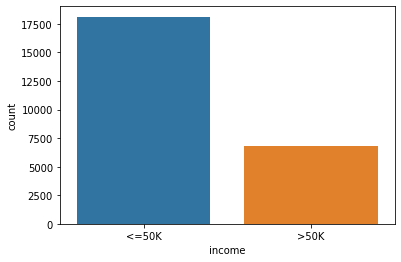

In [202]:
df['income'].value_counts()

# Count of >50K & <=50K
sns.countplot(df['income'],label="Count")


#### Visualizations:

Exploratory data analysis visualizations are created through Tableau and and can be found on the Tableau Public server.

https://public.tableau.com/profile/ravi7131#!/vizhome/Adult_Census_Salary/AdultCensusSalary


## Modeling

In [203]:
# import section

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
import pylab as pl
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

### Encoding: One-Hot Encode Factors

Now, let’s do some data processing to make the data suitable (and often essential) for modeling classifier
models.One-hot encoding is a process to convert to multiple binarized vectors from categorical vectors. Each
1s and 0s binary vector indicates the presence of the original vector class or levels. Categorical variables are
translated into a type in this method that could help make algorithms more efficient; however, the number of
columns is expanded.

In [204]:
# to factoring variables to exclude the unwanted levels

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
#item_encod = list(label_encoder.fit_transform())
df = pd.get_dummies(df)
df.head(5)

,age,hours_per_week,capital,workclass_Federal-gov,workclass_Local-gov,workclass_Not-Working,workclass_Private,workclass_Self-Employed,workclass_State-gov,education_Associates,...,native_country_Asia,native_country_Canada,native_country_Europe,native_country_LatinAmerica,native_country_SE_Asia,native_country_SouthAmerica,native_country_UK,native_country_US,income_<=50K,income_>50K
1,82,18,-4356,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,54,40,-3900,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,41,40,-3900,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5,34,45,-3770,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
6,38,40,-3770,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [205]:
# the target label can be combined into a single feature. value 0 represents income less than or equal to 50k 
# and a value of 1 represents income greater than 50k

df["income"] = df["income_>50K"]
# drop income_>50K & income_<=50K
df.drop(labels=["income_<=50K", "income_>50K"], axis = 1, inplace = True)
df.head(5)

,age,hours_per_week,capital,workclass_Federal-gov,workclass_Local-gov,workclass_Not-Working,workclass_Private,workclass_Self-Employed,workclass_State-gov,education_Associates,...,sex_Male,native_country_Asia,native_country_Canada,native_country_Europe,native_country_LatinAmerica,native_country_SE_Asia,native_country_SouthAmerica,native_country_UK,native_country_US,income
1,82,18,-4356,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,54,40,-3900,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,41,40,-3900,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,34,45,-3770,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,38,40,-3770,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


### Labels Dataset

In [206]:
#extract 'income' column of dataset to labels datasets
x = df.drop(['income'], axis=1)
# then remove income label from the train and test dataset
y = df['income']

# to check the shape of the datasets
x.shape
y.shape

(24958, 48)

(24958,)

### Spliting dataset: Training and Validation Sets

In [207]:
# split the dataset into 70 / 30 ratio with random split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

### Feature Scaling
Next, all the features will be scaled-up. It’s a technique that scales all the characteristics that speeds up
the models’ training time as all features are on the same scale. The code used in the scaling of the function
follows:

In [208]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x.columns)

x_test = pd.DataFrame(scaler.transform(x_test), columns = x.columns)

x_train.shape
x_train.head(10)

x_test.shape
x_test.head(10)

(17470, 48)

,age,hours_per_week,capital,workclass_Federal-gov,workclass_Local-gov,workclass_Not-Working,workclass_Private,workclass_Self-Employed,workclass_State-gov,education_Associates,...,sex_Female,sex_Male,native_country_Asia,native_country_Canada,native_country_Europe,native_country_LatinAmerica,native_country_SE_Asia,native_country_SouthAmerica,native_country_UK,native_country_US
0,-0.264510,-0.107317,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.228100,3.272478,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
1,0.341234,-0.503319,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.228100,-0.305579,...,1.452463,-1.452463,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
2,-0.945973,-0.107317,-0.147556,5.111490,-0.295503,-0.021404,-1.520476,-0.394819,-0.228100,3.272478,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
3,-0.567383,-0.107317,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.228100,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
4,-0.643101,-0.107317,-0.147556,-0.195638,-0.295503,-0.021404,-1.520476,-0.394819,4.384051,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
5,-1.627436,-2.166528,-0.071118,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.228100,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
6,-0.567383,-0.265718,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.228100,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
7,-0.945973,-0.899321,-0.147556,-0.195638,-0.295503,-0.021404,-1.520476,-0.394819,4.384051,-0.305579,...,1.452463,-1.452463,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
8,-1.248845,-0.107317,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.228100,-0.305579,...,1.452463,-1.452463,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
9,0.795542,-0.344918,-0.147556,-0.195638,-0.295503,-0.021404,-1.520476,-0.394819,4.384051,-0.305579,...,1.452463,-1.452463,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972


(7488, 48)

,age,hours_per_week,capital,workclass_Federal-gov,workclass_Local-gov,workclass_Not-Working,workclass_Private,workclass_Self-Employed,workclass_State-gov,education_Associates,...,sex_Female,sex_Male,native_country_Asia,native_country_Canada,native_country_Europe,native_country_LatinAmerica,native_country_SE_Asia,native_country_SouthAmerica,native_country_UK,native_country_US
0,0.038362,-0.503319,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,-0.305579,...,1.452463,-1.452463,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
1,-1.324563,-0.899321,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,-0.305579,...,1.452463,-1.452463,-0.104299,-0.065663,-0.137032,4.721582,-0.121707,-0.093062,-0.063427,-2.941417
2,-1.097409,-0.107317,0.280318,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,-0.305579,...,1.452463,-1.452463,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
3,-0.870255,-0.107317,1.206198,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,-0.305579,...,1.452463,-1.452463,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
4,-0.718819,0.288685,-0.147556,-0.195638,-0.295503,-0.021404,-1.520476,2.532807,-0.2281,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
5,-1.475999,-0.503319,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
6,-1.627436,1.080689,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
7,-0.491665,0.526286,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
8,0.114080,-0.661720,-0.147556,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,-0.305579,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972
9,0.341234,0.288685,0.416851,-0.195638,-0.295503,-0.021404,0.657689,-0.394819,-0.2281,3.272478,...,-0.688486,0.688486,-0.104299,-0.065663,-0.137032,-0.211793,-0.121707,-0.093062,-0.063427,0.339972


### Logistic Regression Model

In [209]:
# import block
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# to create logistic regression model
log_model = LogisticRegression()
log_model.fit(x_train, y_train)
y_pred = log_model.predict(x_test)

print('Logistic Regression accuracy score with all the features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Logistic Regression accuracy score with all the features: 0.8224


In [210]:
acc_log = str(round(metrics.accuracy_score(np.round(y_test),np.round(y_pred)), 2) * 100)+"%"
mse_log = round(metrics.mean_squared_error(y_test,y_pred), 4)
r2s_log = round(metrics.r2_score(y_test,y_pred), 4)


res_df = pd.DataFrame({
        "Model": ['Logistic Regression'],
        'Accuracy': [acc_log],
        'Mean Squared Error' : [mse_log],
        'R2 Score': [r2s_log]
})

res_df


,Model,Accuracy,Mean Squared Error,R2 Score
0,Logistic Regression,82.0%,0.1776,0.117


### Random Forest Model

In [211]:
rf_model = RandomForestRegressor(max_features= 'log2' ,n_estimators=6,criterion='mse',min_samples_leaf=2, 
                                  oob_score=True, n_jobs=-1, random_state=0)
rf_model.fit(x_train, y_train)
rdpreds = rf_model.predict(x_test)
print(rdpreds)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=6, n_jobs=-1, oob_score=True, random_state=0,
                      verbose=0, warm_start=False)

[0.07477969 0.00438596 0.19837059 ... 0.5112781  0.04987495 0.57562418]


In [212]:
acc_rf = str(round(metrics.accuracy_score(np.round(y_test),np.round(rdpreds)), 2) * 100)+"%"
mse_rf = round(metrics.mean_squared_error(y_test, rdpreds), 4)
r2s_rf = round(metrics.r2_score(y_test, rdpreds), 4)

res_rf = pd.DataFrame({
        'Model': ["Random Forest"],
        'Accuracy': [acc_rf],
        'Mean Squared Error' : [mse_rf],
        'R2 Score': [r2s_rf]
})

res_df = res_df.append(res_rf)
res_df

,Model,Accuracy,Mean Squared Error,R2 Score
0,Logistic Regression,82.0%,0.1776,0.1170
0,Random Forest,83.0%,0.1169,0.4191


### K_Nearest Neighbors

In [214]:
knn_model = KNeighborsRegressor(n_neighbors = 12, algorithm = 'ball_tree', leaf_size=1000, metric='manhattan',p=3,n_jobs=-1)
knn_model.fit(x_train, y_train)
knn_preds = knn_model.predict(x_test)
print(knn_preds)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=1000, metric='manhattan',
                    metric_params=None, n_jobs=-1, n_neighbors=12, p=3,
                    weights='uniform')

[0.16666667 0.         0.08333333 ... 0.33333333 0.08333333 0.66666667]


In [173]:
acc_knn = str(round(metrics.accuracy_score(np.round(y_test),np.round(knn_preds)), 2) * 100)+"%"
mse_knn = round(metrics.mean_squared_error(y_test, knn_preds), 4)
r2s_knn = round(metrics.r2_score(y_test, knn_preds), 4)

res_knn =  pd.DataFrame({
            'Model': ["K-Nearest Neighbors"],
            'Accuracy': [acc_knn],
            'Mean Squared Error' : [mse_knn],
            'R2 Score': [r2s_knn]
})

res_df =res_df.append(res_knn)

res_df

,Model,Accuracy,Mean Squared Error,R2 Score
0,Logistic Regression,82.0%,0.1776,0.1170
0,Random Forest,83.0%,0.1169,0.4191
0,K-Nearest Neighbors,81.0%,0.1322,0.3425


## Results

The results of the accuracy of various models are listed below. The Random Forest Model achieved
the highest accuracy and the ultimately proposed model of all models explored in this project.

In this project, the popluar analysis and modeling approaches are used to keep it limited to the scope of
the project. Nonetheless, more advanced modeling methods such as NNET, Deep Neural Network,
etc. as well as modeling with features based on their importance could be used as a potential extension of
this project to further improve the performance. In addition, other significant comparison quality features
including Sensitivity, Specificity, Prevalence, F1 Score, AUC, ROC curve can be explored further.